In [16]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import BatchNormalization
import numpy as np


In [17]:
# Paths to your local dataset
base_dir = '/kaggle/input/rp-rice-leaf-dataset/Rice Leaf Diseases Dataset'

In [18]:
# Image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 64

In [19]:
# Data augmentation with additional techniques
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% of data for validation
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 12800 images belonging to 4 classes.
Found 3200 images belonging to 4 classes.


In [20]:
# Load the DenseNet121 model with pre-trained weights, excluding the top layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [21]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout rate
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout rate
predictions = Dense(4, activation='softmax')(x)  # 4 classes

In [22]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
# Unfreeze more layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])# Unfreeze more layers for fine-tuning

In [24]:
# Implement callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [25]:
# Train the model with more epochs and callbacks
history = model.fit(
    train_generator,
    epochs=20,  # Increased epochs for better training
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728457930.039214     138 service.cc:145] XLA service 0x7b56c0003cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728457930.039278     138 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728458044.292608     138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/step - accuracy: 0.6986 - loss: 0.8762 - val_accuracy: 0.5638 - val_loss: 2.5043 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9318 - loss: 0.1987 - val_accuracy: 0.7203 - val_loss: 1.4416 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.9496 - loss: 0.1575 - val_accuracy: 0.6956 - val_loss: 1.5000 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.9576 - loss: 0.1249 - val_accuracy: 0.5372 - val_loss: 3.3371 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.9634 - loss: 0.1037 - val_accuracy: 0.7331 - val_loss: 2.2215 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.9681 - loss: 0.0936 - val_accuracy: 0.6922 - val_loss: 2.4369 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.9641 - loss: 0.1092 - val_

In [26]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc:.2f}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7265 - loss: 1.3844
Validation accuracy: 0.73


In [27]:
# Import necessary libraries for plotting and evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step


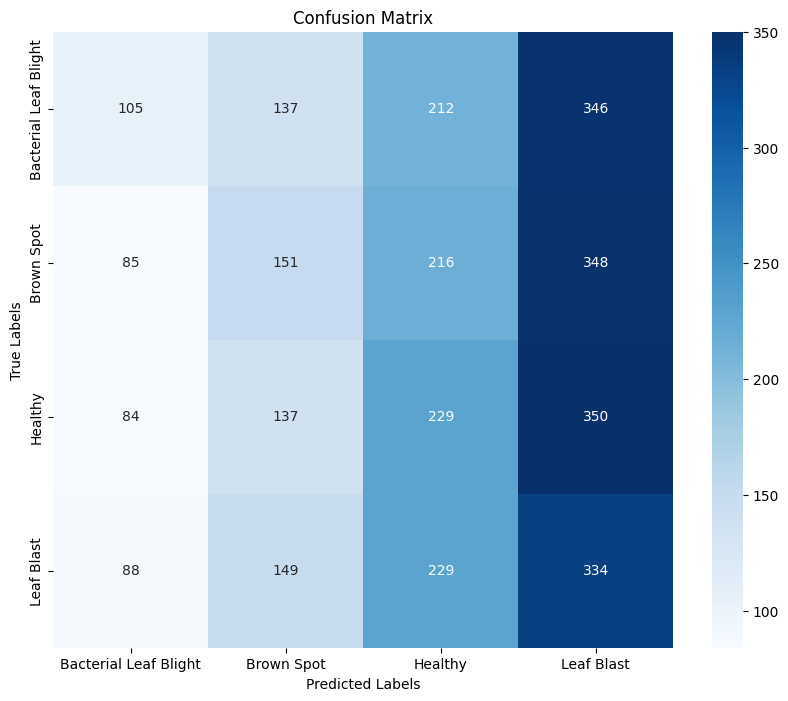

Classification Report:
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.29      0.13      0.18       800
           Brown Spot       0.26      0.19      0.22       800
              Healthy       0.26      0.29      0.27       800
           Leaf Blast       0.24      0.42      0.31       800

             accuracy                           0.26      3200
            macro avg       0.26      0.26      0.24      3200
         weighted avg       0.26      0.26      0.24      3200



In [28]:
# Predict the validation data
val_preds = model.predict(val_generator)
val_preds_classes = np.argmax(val_preds, axis=1)

# Get true labels
val_true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_preds_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Classification report
print('Classification Report:')
print(classification_report(val_true_classes, val_preds_classes, target_names=class_labels))